In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Generation

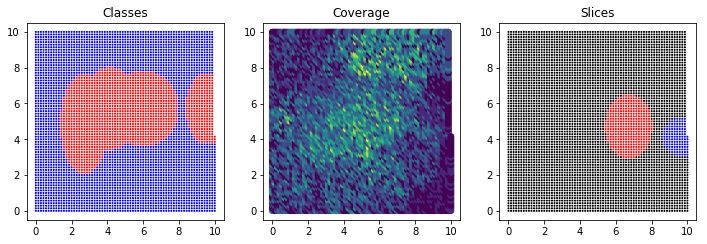

In [2]:
from torch.utils.data import DataLoader

from metal.utils import SlicingDataset
from metal.contrib.slicing.synthetics.geometric_synthetics import generate_dataset
from metal.utils import split_data

NUM_SLICES = 2
K = 2
M = 20
N = 5000
BATCHSIZE = 32
unipolar = True
seed = None

Z_kwargs = {'num_slices': NUM_SLICES}
L, X, Y, Z, _ = generate_dataset(K, M, N, 
                                 Z_kwargs=Z_kwargs,
                                 unipolar=unipolar,
                                 slice_source="maxmin",
                                 seed=seed)

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)

## LabelModel

In [3]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])

from metal.metrics import accuracy_score

Y_train_ps = label_model.predict_proba(Ls[0])
Ys[0] = Y_train_ps

Y_dev_ps = label_model.predict_proba(Ls[0])
Y_dev_p = label_model.predict(Ls[1])
accuracy_score(Ys[1], Y_dev_p)

0.664

In [4]:
import torch
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

Ls_tensors = [torch.Tensor(np.asarray(L.todense())) for L in Ls]

train_loader = DataLoader(
    SlicingDataset(Xs[0], Ls_tensors[0], Y_train_ps),
    batch_size=BATCHSIZE,
    shuffle=True
)

dev_loader = DataLoader(SlicingDataset(Xs[1], Ys[1]))

## SliceMaster

In [5]:
# Define custom metrics
from metal.metrics import accuracy_score
from metal.utils import convert_labels

def calc_L_acc(model, dataloader):
    X, L, Y = dataloader.dataset.data
    L_probs = model.predict_L_proba(X)
    
    if model.indicator:
        L = L.clone()
        L[L == 2] = 1
    else:
        raise NotImplemented("Cannot evaluate L predictions if model.indicator=False")
    metrics = {"train/L_acc": accuracy_score(L.flatten(), np.round(L_probs).flatten())}
    return metrics

def calc_Y_heads_acc(model, dataloader):
    X, Y = dataloader.dataset.data
    L_probs, Y_off_probs, Y_on_probs = model.predict_all_proba(X)

    Y_off_preds = convert_labels(np.round(Y_off_probs), "onezero", "categorical")
    Y_on_preds = convert_labels(np.round(Y_on_probs), "onezero", "categorical")
    
    metrics = {
        "valid/Y_off_acc": accuracy_score(Y, Y_off_preds),
        "valid/Y_on_acc": accuracy_score(Y, Y_on_preds),     
    }
    return metrics

In [6]:
em_config = {
    "layer_out_dims": [2, 5, 5, 2],
    "disable_prog_bar": True,
    "verbose": False,
    "seed": 123,
}

sm_config = {
    "L_weight": 0.1,
    "Y_off_weight": 0.1,
    "vanilla": False,
    "online_head": True,
    "indicator": True,
    "mask_abstains": False,
    "verbose": True,
}

train_kwargs = {
    "n_epochs": 20,
    "lr": 0.01,
    "l2": 0.0,
    "log_unit": "epochs",
    "log_train_metrics_func": calc_L_acc,
    "log_train_metrics": ["train/loss", "train/L_acc"],
    "log_train_every": 1,
    "log_valid_every": 1,
    "log_valid_metrics_func": calc_Y_heads_acc,
    "log_valid_metrics": ["valid/Y_off_acc", "valid/Y_on_acc"],
    "checkpoint": True,
    "checkpoint_metric": "valid/Y_on_acc",
}

In [7]:
from metal.end_model import EndModel
from metal.contrib.slicing.slice_model import SliceMaster

base_model = EndModel(**em_config)
model = SliceMaster(base_model, m=Ls[0].shape[1], **sm_config)
model.train_model(train_loader, valid_data=dev_loader, **train_kwargs)
model.score((Xs[2], Ys[2]))

Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=5, out_features=20, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
  (Y_head_on): Linear(in_features=5, out_features=1, bias=True)
)

[1 epo]: train/loss=0.666, train/L_acc=0.916, valid/Y_off_acc=0.326, valid/Y_on_acc=0.326
Saving model at iteration 1 with best score 0.326
[2 epo]: train/loss=0.645, train/L_acc=0.916, valid/Y_off_acc=0.374, valid/Y_on_acc=0.394
Saving model at iteration 2 with best score 0.394
[3 epo]: train/loss=0.641, train/L_acc=0.915, valid/Y_off_acc=0.353, valid/Y_on_acc=0.368
[4 epo]: train/loss=0.637, train/L_acc=0.915, valid/Y_of

0.7472